<a href="https://colab.research.google.com/github/kamalsky/VGGish/blob/master/yamnet_audio_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yamnet
## Downloading audios and model

In [0]:
!curl -L -o audio_folder1.zip https://www.dropbox.com/sh/71c4vghy7fi50f4/AAD-3QaJXpMM0LWAm0cR_g7Aa/audio_folder1?dl=1
!curl -L -o audio_folder2.zip https://www.dropbox.com/sh/71c4vghy7fi50f4/AACbIZpHndt_rQ6YMVStqDLna/audio_folder2?dl=1

!unzip audio_folder1.zip -d audio_folder1
!unzip audio_folder2.zip -d audio_folder2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1744M  100 1744M    0     0  15.8M      0  0:01:50  0:01:50 --:--:-- 17.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1674M  100 1674M    0     0  14.5M      0  0:01:55  0:01:55 --:--:-- 16.7M
Archive:  audio_folder1.zip
mapname:  conversion of  failed
 extracting: audio_folder1/moonchild.m4a  
 extracting: audio_folder1/forever rain.m4a  
 extracting: audio_folder1/ford. - Dusk.m4a  
 extracting: au

In [0]:
!git clone https://github.com/tensorflow/models.git
!wget https://storage.googleapis.com/audioset/yamnet.h5

Cloning into 'models'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 32607 (delta 25), reused 36 (delta 12), pack-reused 32547
Receiving objects: 100% (32607/32607), 511.76 MiB | 36.94 MiB/s, done.
Resolving deltas: 100% (20862/20862), done.
Checking out files: 100% (2486/2486), done.
--2020-03-09 16:31:59--  https://storage.googleapis.com/audioset/yamnet.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15296092 (15M) [application/octet-stream]
Saving to: ‘yamnet.h5’

yamnet.h5           100%[===================>]  14.59M  14.0MB/s    in 1.0s    

2020-03-09 16:32:00 (14.0 MB/s) - ‘yamnet.h5’ saved [15296092/15296092]



In [0]:
%cd models/research/audioset/yamnet

/content/models/research/audioset/yamnet


## Implementing main functions

In [0]:
!pip install SoundFile
!pip install pydub

In [0]:
# Imports.
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pydub import AudioSegment
import os

import params
import yamnet as yamnet_model
import tensorflow as tf

In [0]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.
graph = tf.Graph()
with graph.as_default():
    yamnet = yamnet_model.yamnet_frames_model(params)
    yamnet.load_weights('/content/yamnet.h5')

def to_numpy_array(sound):
        """
        Returns a numpy array. The shape of this array is either (nsamples, nchannels), if nchannels
        is greater than 1, or else just (nsamples,).
        """
        dtype_dict = {
                        1: np.int8,
                        2: np.int16,
                        4: np.int32
                     }
        dtype = dtype_dict[sound.sample_width]
        arr = np.array(sound.get_array_of_samples(), dtype=dtype)
        return np.reshape(arr, (-1, sound.channels)).squeeze()

def load_audio(m4a_file_path):
  sound = AudioSegment.from_file(m4a_file_path)  # Read wav, mp3 or m4a file
  fixed_length = 10*60*1000 # 10 minutes (miliseconds)
  if len(sound) < fixed_length:
    silence = AudioSegment.silent(duration=fixed_length - len(sound))
    sound = sound + silence
  else:
    sound = sound[0:fixed_length]
  sr = 44100
  sound = sound.set_frame_rate(sr)
  sound = sound.set_channels(1) # Multiple channels to mono
  wav_data = to_numpy_array(sound)

  #audio = AudioSegment.from_file(m4a_file_path)
  #audio.export("temp.wav", format="wav")
  #wav_data, sr = sf.read("temp.wav", dtype=np.int16)
  waveform = wav_data / 32768.0
  # The graph is designed for a sampling rate of 16 kHz, but higher rates 
  # should work too.
  params.SAMPLE_RATE = sr
  print("Sample rate =", params.SAMPLE_RATE)
  return waveform

def run_model(waveform):
  with graph.as_default():
    classes, spectrogram = yamnet.predict(np.reshape(waveform, [1, -1]), steps=1)
  return classes, spectrogram

import os.path

def process_file(m4a_file_path,dst_folder):
  # Check if already exists
  filename = m4a_file_path.split("/")[-1].split(".")[0]
  if not os.path.isfile(f"{dst_folder}/{filename}.png"):
    waveform = load_audio(m4a_file_path)
    classes, spectrogram = run_model(waveform)    
    plt.imsave(f"{dst_folder}/{filename}.png",spectrogram.T)
    np.save(f"{dst_folder}/{filename}.npy",classes)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
m4a_folder = '/content/audio_folder1/'
for m4a_file_path in os.listdir(m4a_folder):
  process_file(m4a_folder + "/" + m4a_file_path,"/content/drive/My Drive/yamnet/data_folder1")
  print("Processed " + m4a_file_path)

m4a_folder = '/content/audio_folder2/'
for m4a_file_path in os.listdir(m4a_folder):
  process_file(m4a_folder + "/" + m4a_file_path,"/content/drive/My Drive/yamnet/data_folder2")
  print("Processed " + m4a_file_path)

# NumPy array files (NPY) of shape [<# patches>, <# STFT frames in an patch>, MEL_BANDS]

Processed Jaded x Black Caviar x Antony & Cleopatra - Slippin'.m4a
Processed picasso - kewtiie, gill (cover).m4a
Processed What So Not & Skrillex - Goh feat. KLP (Champagne Drip Remix).m4a
Processed Jay Gwuapo - One Chance.m4a
Processed Billx & Fortanoiza - Spirit Of India (UCantStopTheRave Records).m4a
Processed Warface ft. Sovereign King - We All Live For This (Official anthem).m4a
Processed Bizzy Banks - Ready Or Not.m4a
Processed Virtual Self - Particle Arts (Divine Remix).m4a
Processed Mako - Way Back Home (Akari Remix).m4a
Processed WINTERRR - Mindbender [DROP IT NETWORK EXCLUSIVE].m4a
Processed Mua Phi Truong Ft. Rock Star 2018 - Future Ft. Viet Puzo Remix (Ha Banana Team).m4a
Processed scene feat. ghetto guitar(prod. soriano).m4a
Processed Lemay - Say You Do (feat. Belle Jewel) (Fynn Hufler Remix).m4a
Processed DJ Blyatman - Dragunov.m4a
Processed Agressor Bunx - Death Meadow (Eatbrain069).m4a
Processed Fools (Devilboy Remix)- Madison Beer.m4a
Processed San Holo - lift me from 

# Visualization over one single audio


In [0]:
m4a_file_path = '/content/audio_folder1/#BanMDN Ekakah Maves Hunnaanamey by Reehaan.m4a'
waveform = load_audio(m4a_file_path)
classes, spectrogram = run_model(waveform)

Sample rate = 44100


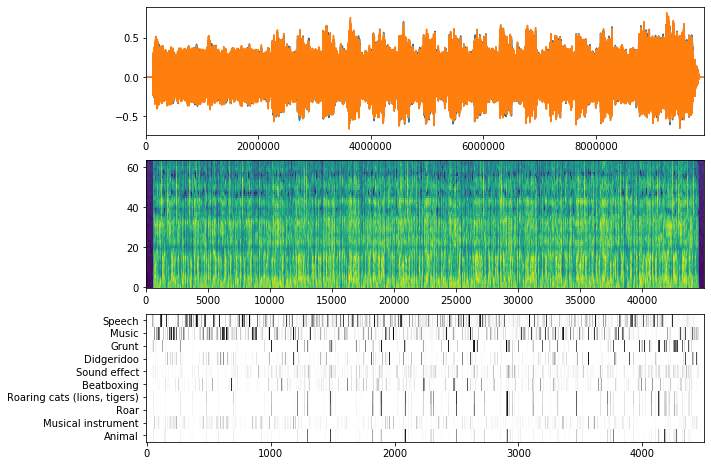

In [0]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(classes, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(classes[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, classes.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))